In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(mclust)
library(cowplot)
library(tidyverse)
library(reshape)
library(SingleR)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(patchwork)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
      plot.title = element_text(size = 10),
    text = element_text(size = 10, colour = "black"),
    legend.text = element_text(size = 10),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: 'DT'


The following object is masked from 'package:SeuratObject':

    JS


The following object is masked from 'package:Seurat':

    JS



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


here() starts at /auto/brno2/home/vercanie/DIA

Package 'mclust' version 5.4.8
Type 'citation("mclust")' for citing this R package in publica

### Read datasets

In [2]:
plan("multisession")

In [3]:
cd8_full_filt  <- readRDS("data/processed/cd8_full_filt.rds")
cd8_subcluster  <- readRDS("data/processed/cd8_subcluster.rds")
nk_subcluster  <- readRDS("data/processed/nk_subcluster.rds")
unc_subcluster  <- readRDS("data/processed/unc_subcluster.rds")


# Full dataset

## Cluster composition

In [10]:
cd8_full_filt@misc$colors_annotations_l1  <- c("slategrey","#44918b",  "grey77")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



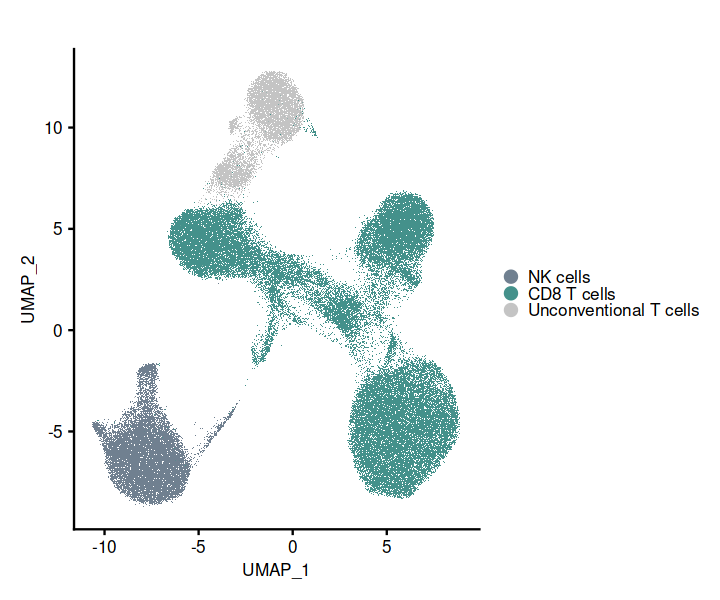

In [192]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd8_full_filt, label = F, raster = T, group.by = "annotations_l1",
       cols = cd8_full_filt@misc$colors_annotations_l1) + ggtheme() + ggtitle("")
dimplot1

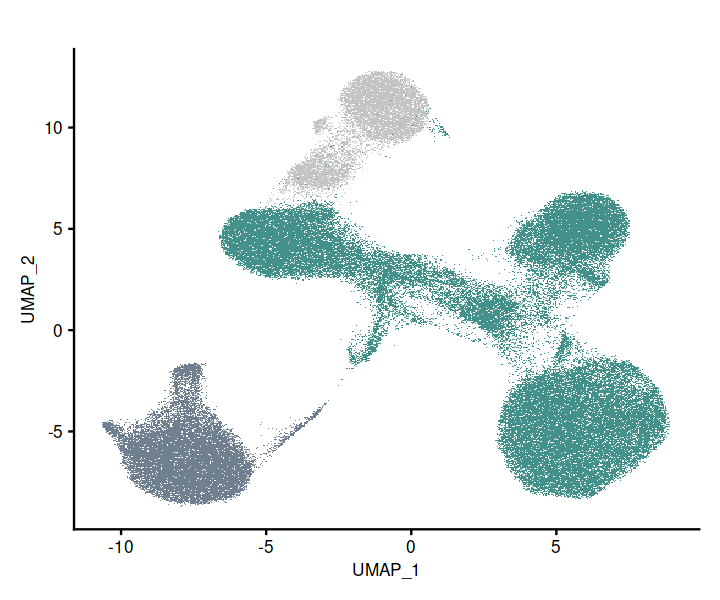

In [193]:
dimplot1 + NoLegend()
ggsave("dimplot_cd8_full_filt.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_cd8_full_filt.svg", width = 12, height = 12, units = "cm")

In [122]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd8_full_filt@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l1) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l1", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l1")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


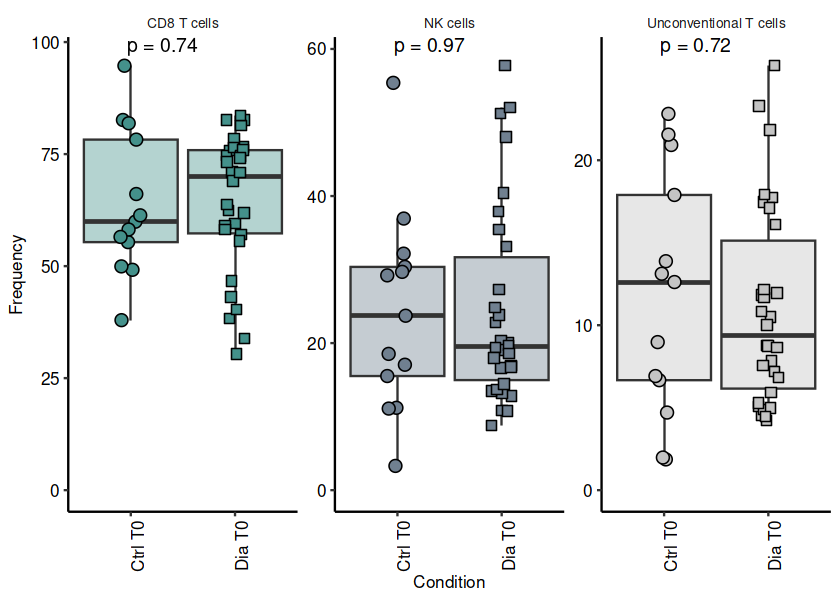

In [138]:
options(repr.plot.width = 7, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [141]:
ggsave("figures/boxplot_cd8_full_filt_1.png", width = 8, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_full_filt_1.svg", width = 8, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


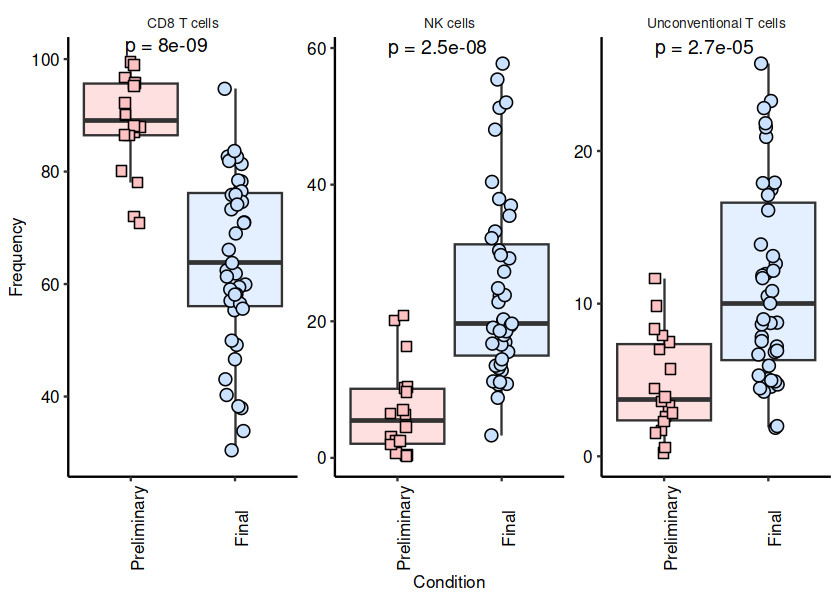

In [148]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.7, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [149]:
ggsave("figures/boxplot_cd8_full_filt_2.png", width = 8, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_full_filt_2.svg", width = 8, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


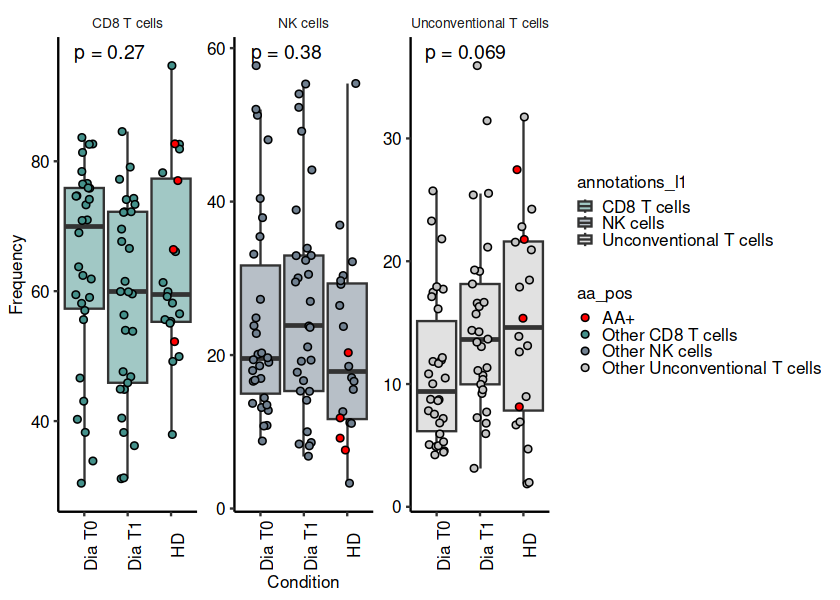

In [152]:
options(repr.plot.width = 7, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l1)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = annotations_l1)) +
  scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', aes(fill = aa_pos, shape = aa_pos), color = "black") + 
  scale_fill_manual(values = c("red","#44918b", "slategrey", "grey77"))+
  
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [153]:
ggsave("figures/boxplot_cd8_full_filt_3.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_full_filt_3.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


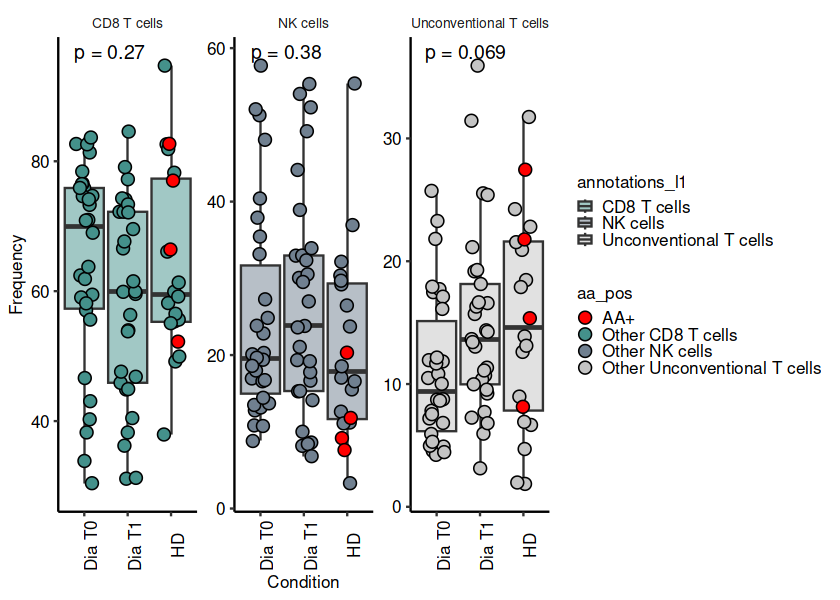

In [134]:
p3

### Save freqencies

In [135]:
df4

Sample_ID,annotations_l1,freq,Condition,Disease,Sex,Age,Age_group,Patient_ID,Time,Experiment_ID
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
148,NK cells,0.031212485,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,CD8 T cells,0.870348139,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Unconventional T cells,0.098439376,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
149,NK cells,0.025270758,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,CD8 T cells,0.957882070,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,Unconventional T cells,0.016847172,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
150,NK cells,0.003314917,Dia T0,Dia,M,3.7,1,105,T0,Exp08
150,CD8 T cells,0.994475138,Dia T0,Dia,M,3.7,1,105,T0,Exp08
150,Unconventional T cells,0.002209945,Dia T0,Dia,M,3.7,1,105,T0,Exp08


In [136]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd8_full_filt.csv", row.names = FALSE)

### Save plot

In [52]:
layout <- "
AA##
AA##
BBBB
CCCC
"

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


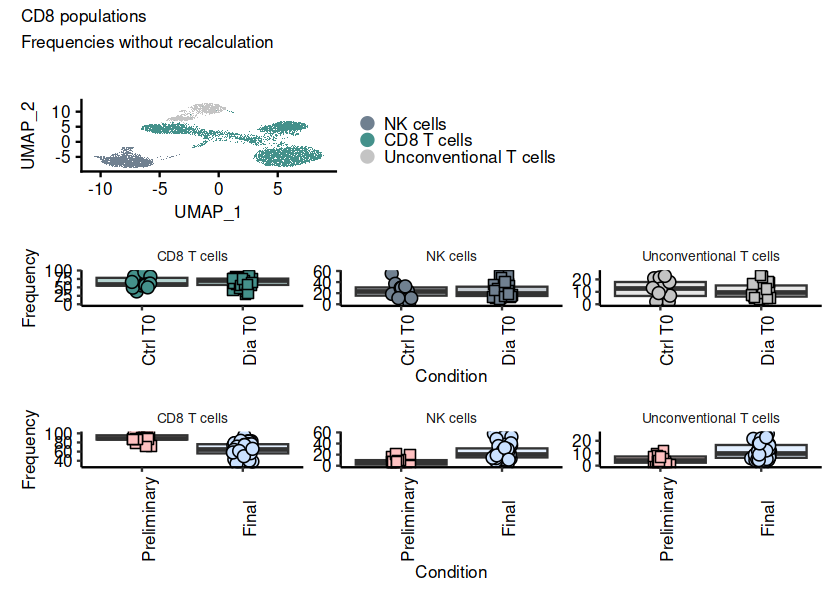

In [53]:
p3  <- dimplot1+p1+p2 + plot_layout(design = layout) + 
plot_annotation(title = "CD8 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p3

In [54]:
ggsave(filename="02_Main_populations_CD8.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


# CD8 subcluster 

## Cluster composition

In [154]:
cd8_subcluster@misc$cols_annotations_l2  <- c(
     "#6FC4AD", # Tcm2 
     "#92c0df", #Naive
     "#24693d", # TEM ISAGhi
     "#75bc69",  # Tem
     "#b3e0a6" , # Tcm1
     "#88aa00" , # Proliferating
     "#499894", # Temra 
     "#4878a6")

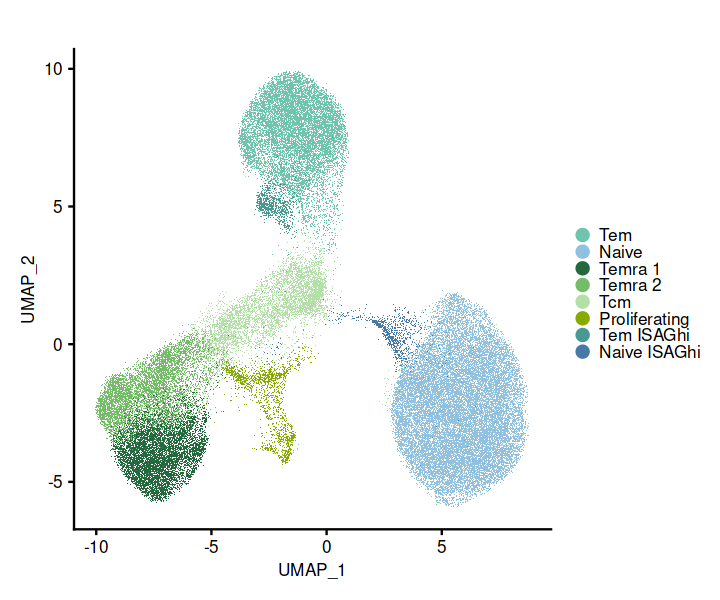

In [155]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd8_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd8_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

In [263]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd8_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l2) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l2", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l2")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


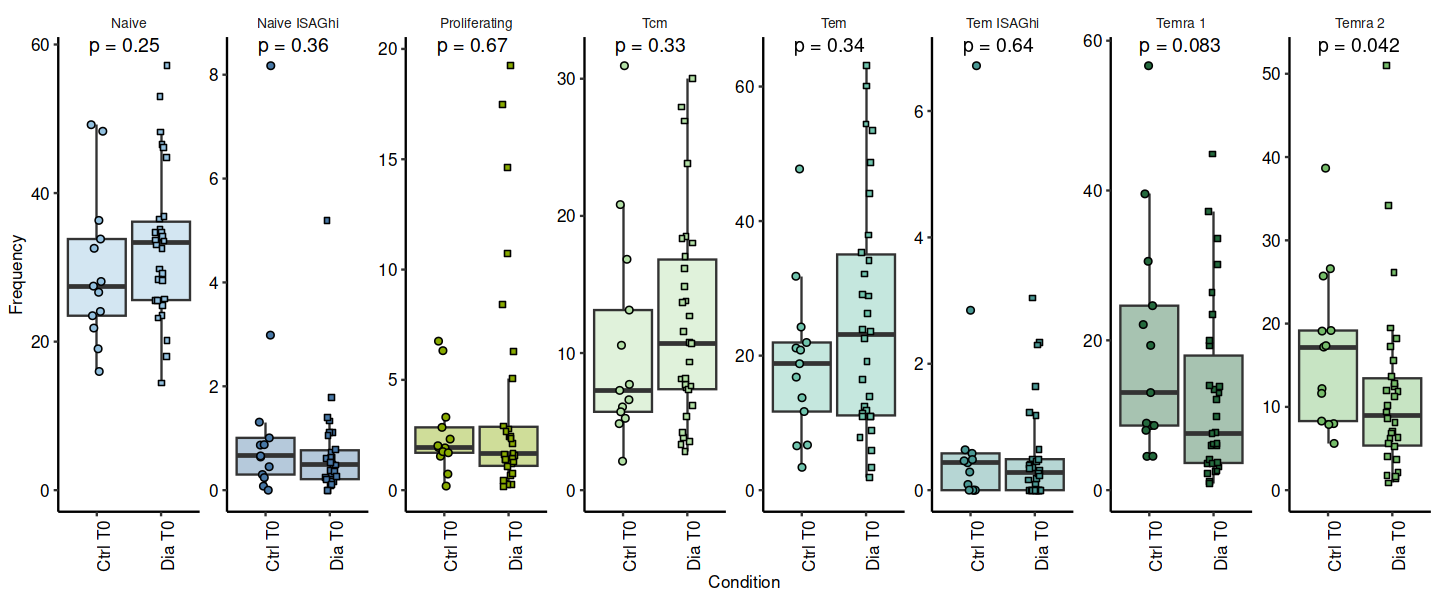

In [264]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l2)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = annotations_l2, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd8_subcluster@misc$cols_annotations_l2[c(2,8,6,5,1,7,3,4)])+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [158]:
ggsave("figures/boxplot_cd8_subcluster_1.png", width = 20, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_subcluster_1.svg", width = 20, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


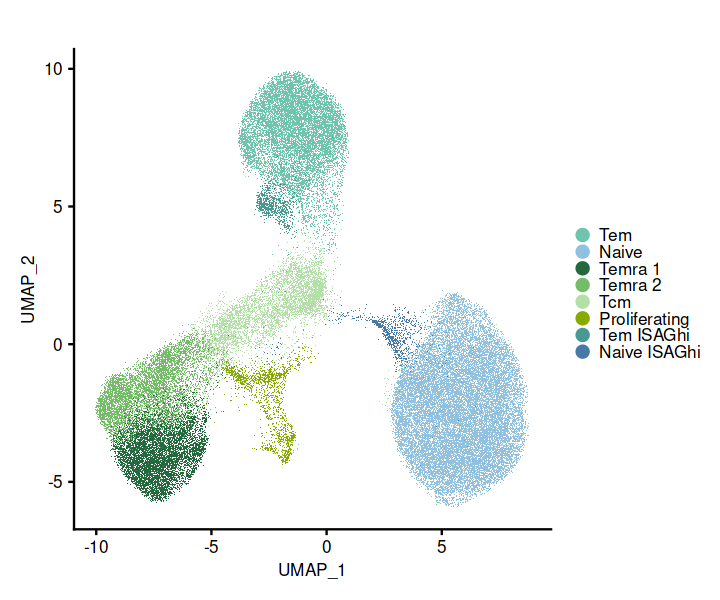

In [190]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd8_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd8_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

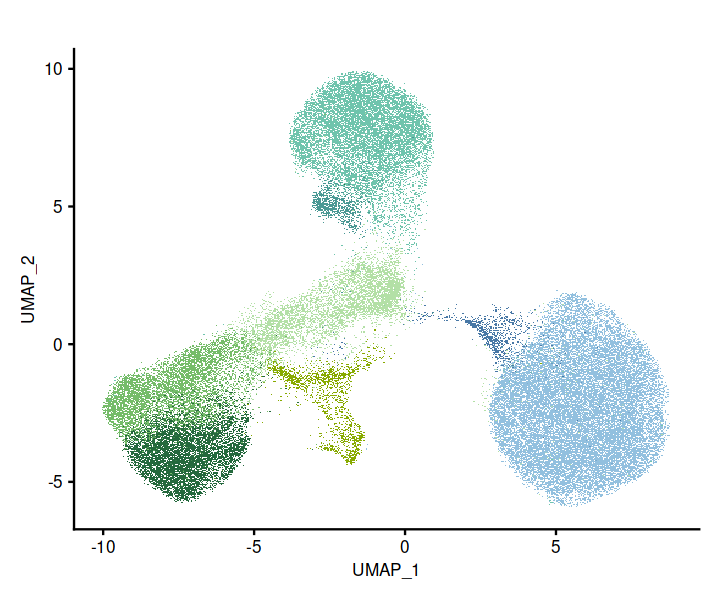

In [191]:
dimplot1 + NoLegend()
ggsave("dimplot_cd8_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_cd8_subcluster.svg", width = 12, height = 12, units = "cm")

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


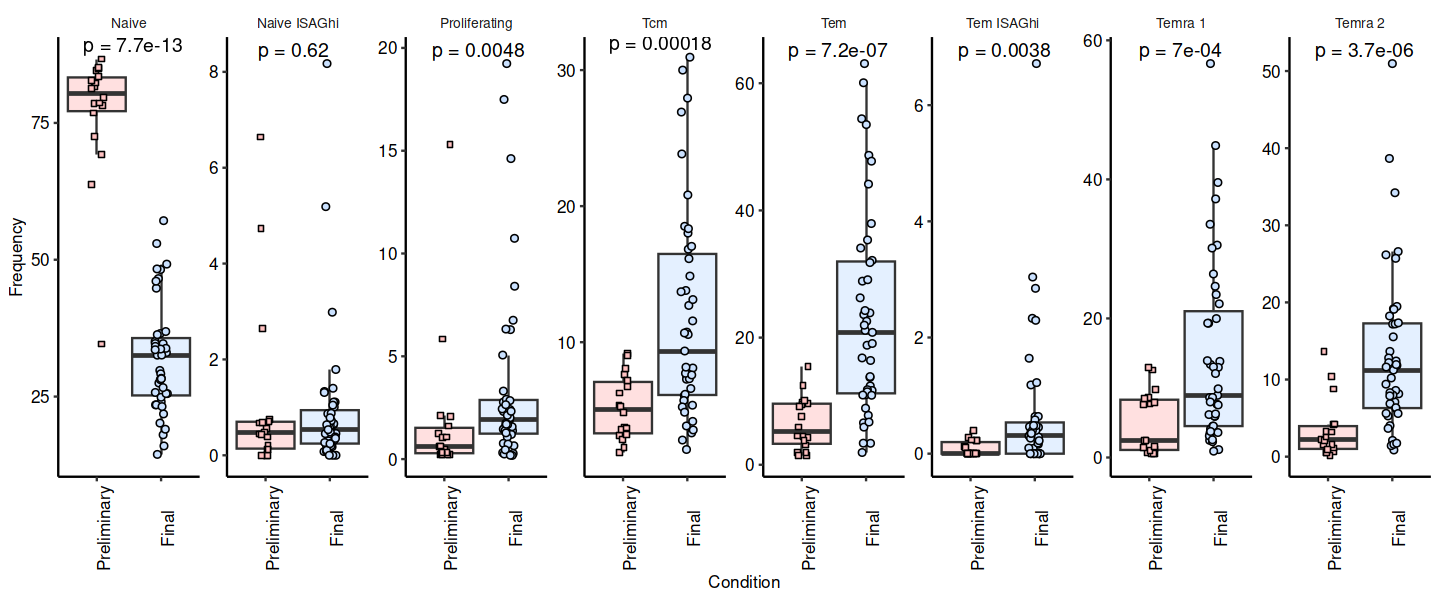

In [160]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [161]:
ggsave("figures/boxplot_cd8_subcluster_2.png", width = 20, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_subcluster_2.svg", width = 20, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


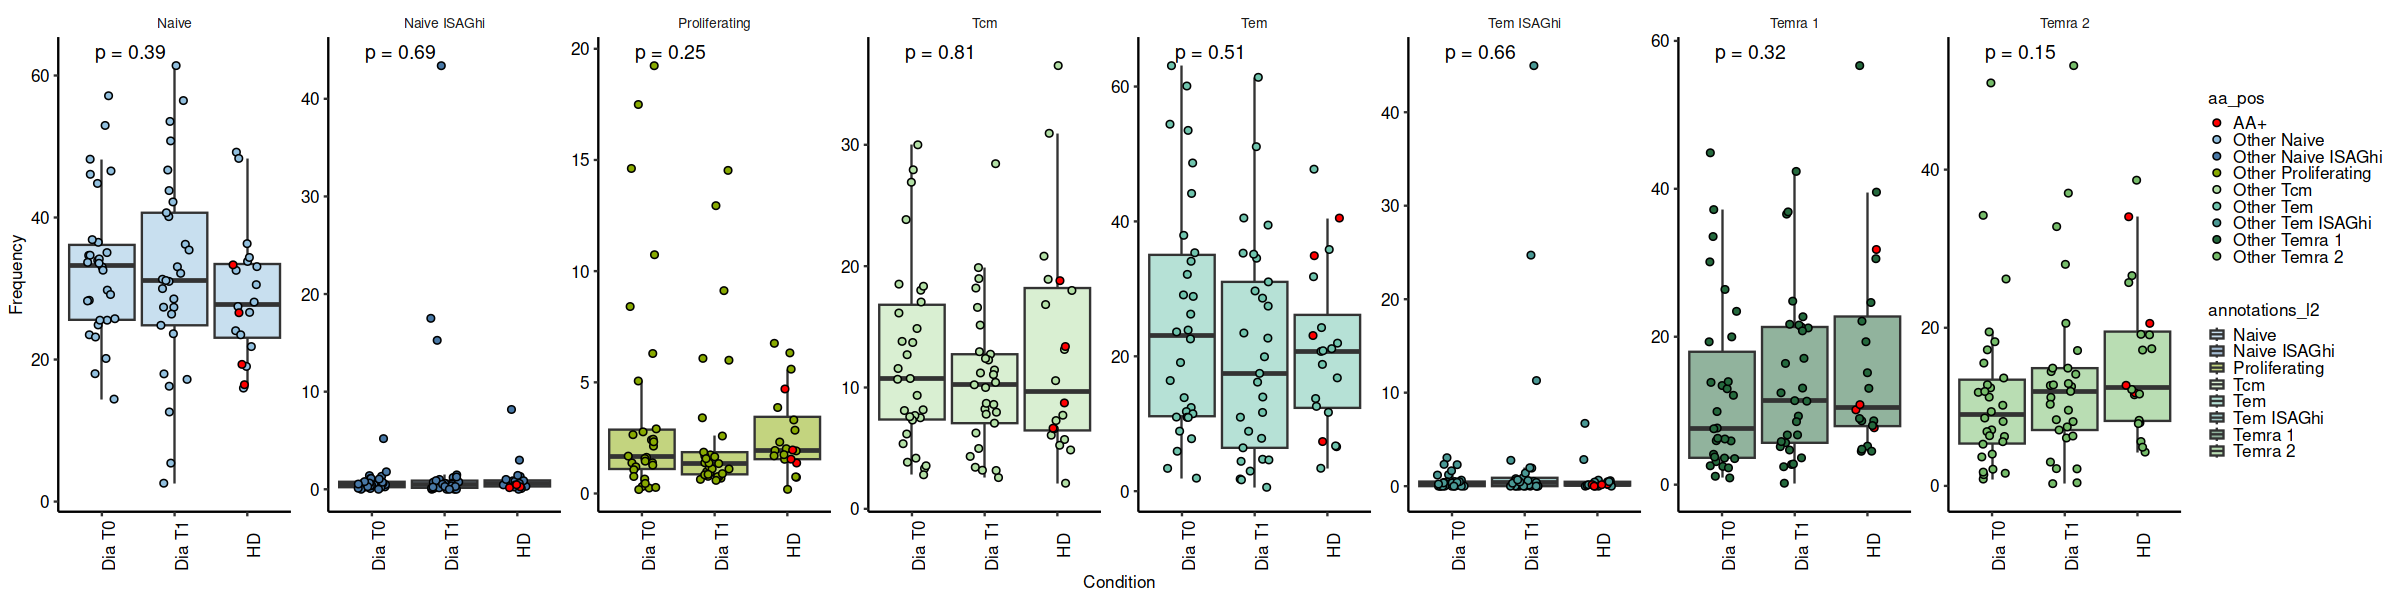

In [164]:
options(repr.plot.width = 20, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l2)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = annotations_l2)) +
  scale_fill_manual(values = c(cd8_subcluster@misc$cols_annotations_l2[c(2,8,6,5,1,7,3,4)]))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', aes(fill = aa_pos, shape = aa_pos), color = "black") + 
  scale_fill_manual(values = c("red",cd8_subcluster@misc$cols_annotations_l2[c(2,8,6,5,1,7,3,4)]))+
  
  facet_wrap(~annotations_l2, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [166]:
ggsave("figures/boxplot_cd8_subcluster_3.png", width = 30, height = 8, units = "cm")
ggsave("figures/boxplot_cd8_subcluster_3.svg", width = 30, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [135]:
df4

Sample_ID,annotations_l1,freq,Condition,Disease,Sex,Age,Age_group,Patient_ID,Time,Experiment_ID
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
148,NK cells,0.031212485,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,CD8 T cells,0.870348139,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Unconventional T cells,0.098439376,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
149,NK cells,0.025270758,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,CD8 T cells,0.957882070,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,Unconventional T cells,0.016847172,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
150,NK cells,0.003314917,Dia T0,Dia,M,3.7,1,105,T0,Exp08
150,CD8 T cells,0.994475138,Dia T0,Dia,M,3.7,1,105,T0,Exp08
150,Unconventional T cells,0.002209945,Dia T0,Dia,M,3.7,1,105,T0,Exp08


In [265]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_cd8_subcluster.csv", row.names = FALSE)

# NK subcluster 

## Cluster composition

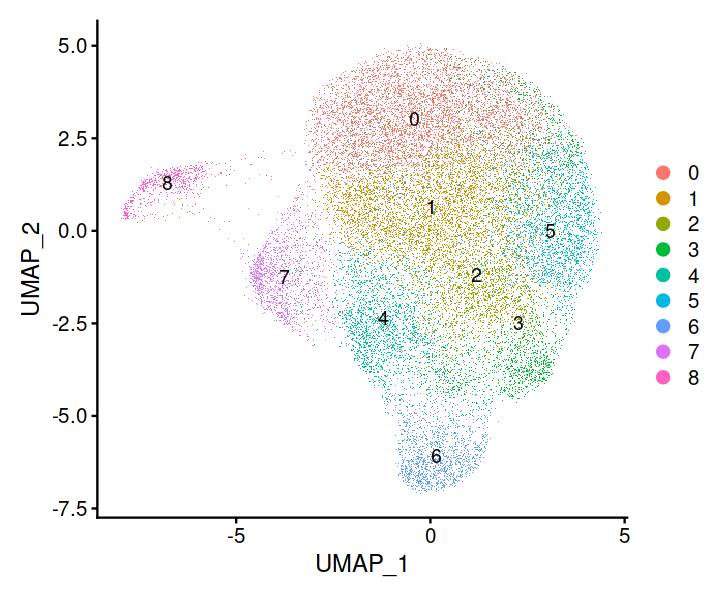

In [170]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(nk_subcluster, label = T, raster = T) 
dimplot1

In [171]:
nk_subcluster@meta.data  <- nk_subcluster@meta.data  %>% 
mutate(annotations_l3 = recode_factor(seurat_clusters, 
                                     "0" = "Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-",
                                     "1" = "Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-",
                                     "2" = "gd T cells",
                                     "3" = "gd T cells",
                                     "4" = "Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+",
                                     "5" = "Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-",
                                     "6" = "Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+",
                                     "7" = "ISAGhi",
                                     "8" = "Proliferating"))

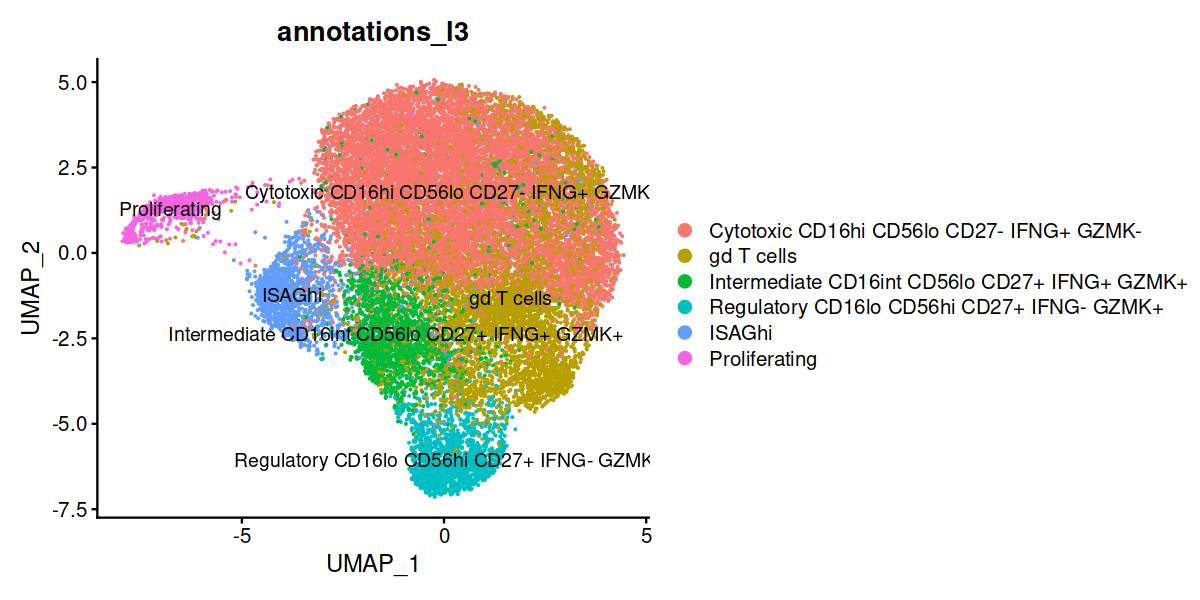

In [172]:
options(repr.plot.width = 10, repr.plot.height = 5)

DimPlot(nk_subcluster, label = T, group.by = "annotations_l3")

In [167]:
nk_subcluster@misc$cols_annotations_l3  <- c(
     "slategray",
    "#b9ddf1",
    "dodgerblue",
     "blue",
    "#499894"  ,
     "#398949",
    "#4878a6" ,
     "#86BCB6" ,
     "#b3e0a6",
    "blue")

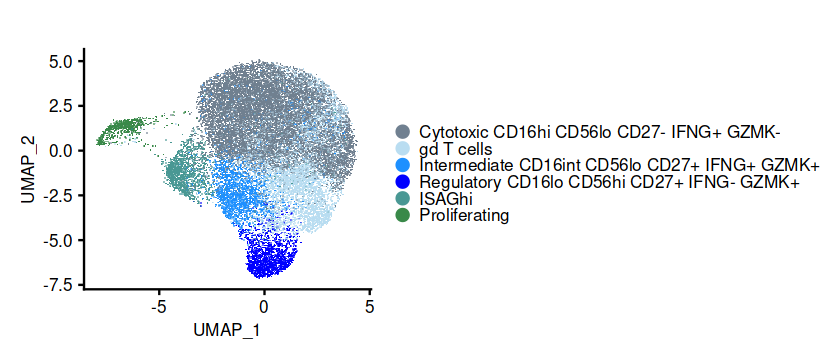

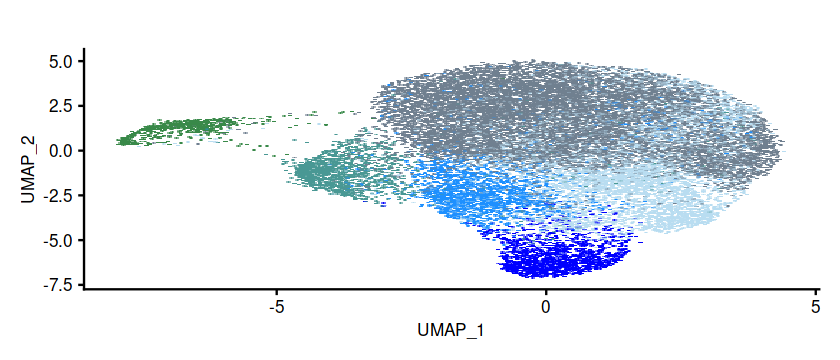

In [189]:
options(repr.plot.width = 7, repr.plot.height = 3)

dimplot1  <- DimPlot(nk_subcluster, label = F, raster = T, group.by = "annotations_l3",
                    cols = nk_subcluster@misc$cols_annotations_l3, pt.size = 2) + 
ggtheme() + 
ggtitle("")
dimplot1
dimplot1 + NoLegend()
ggsave("dimplot_nk_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_nk_subcluster.svg", width = 12, height = 12, units = "cm")

In [382]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- nk_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l3) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l3", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l3")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


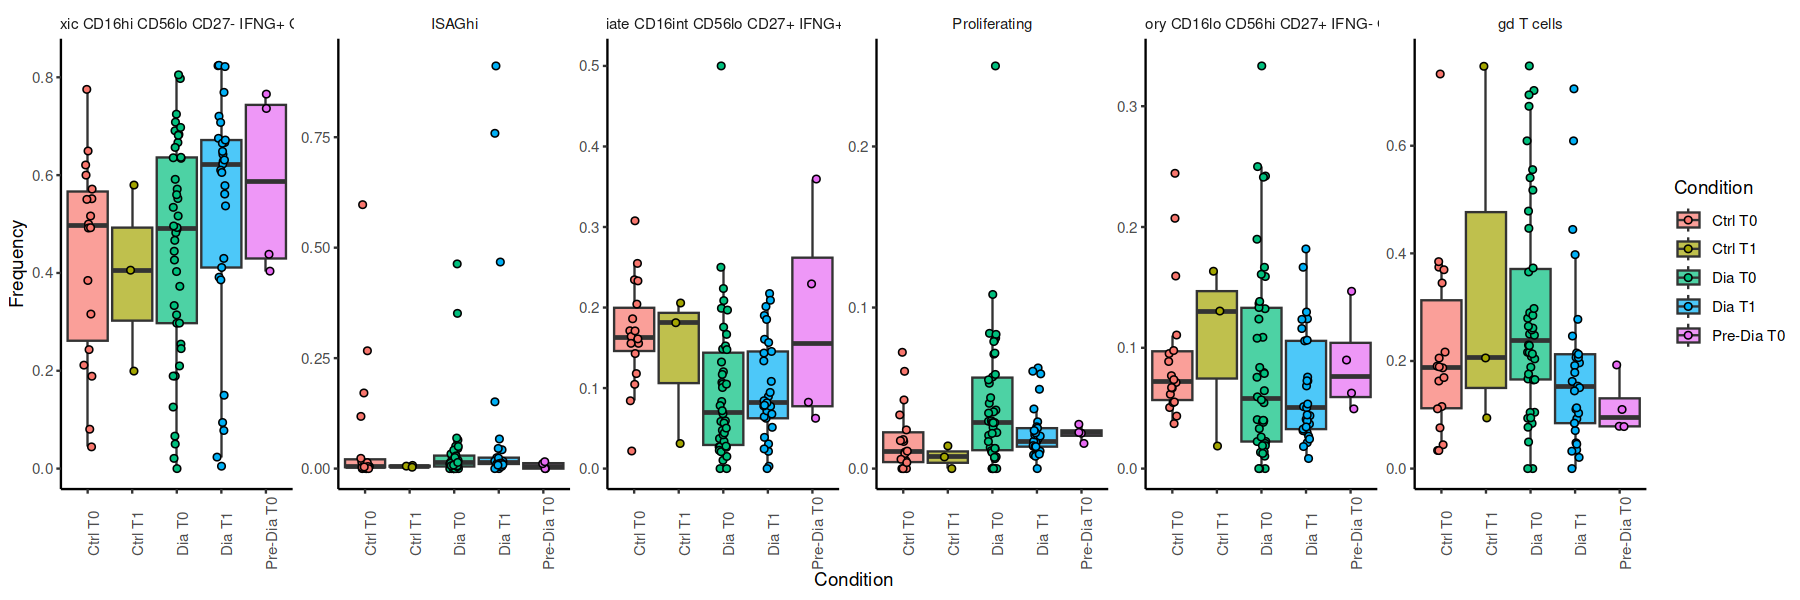

In [274]:
p0

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


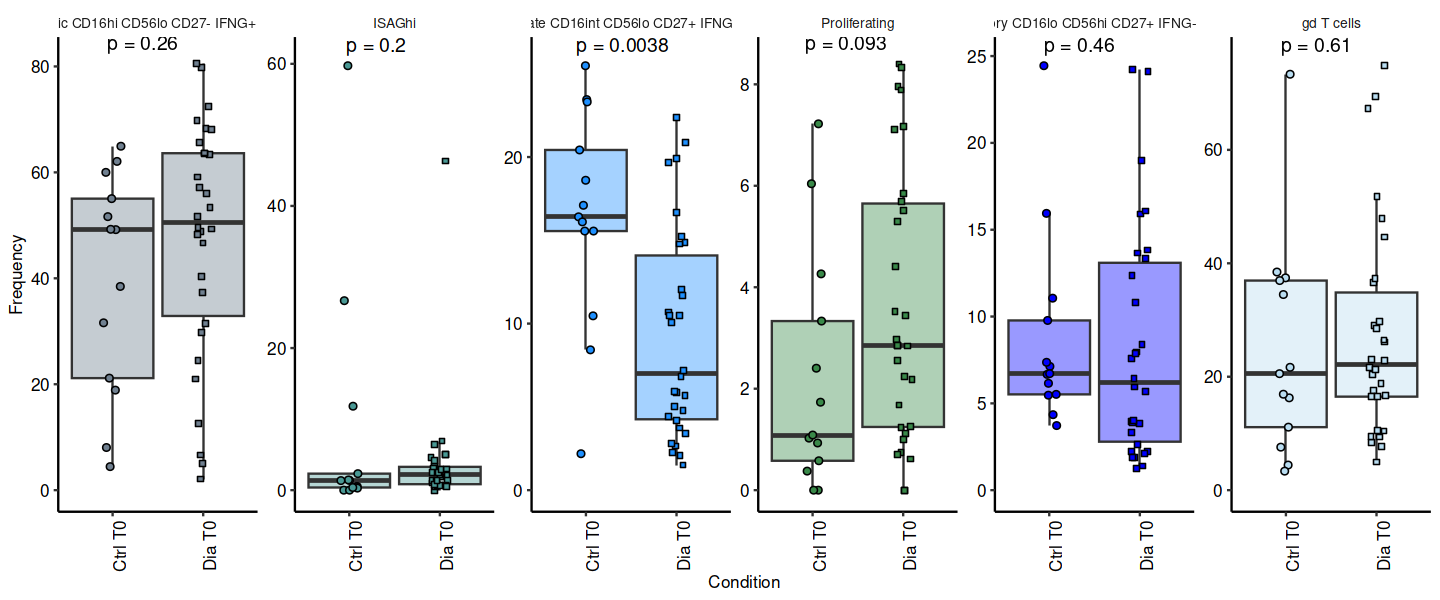

In [268]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l3)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = annotations_l3, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = nk_subcluster@misc$cols_annotations_l3[c(1,5,3,6,4,2)]) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [176]:
ggsave("figures/boxplot_nk_subcluster_1.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_nk_subcluster_1.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


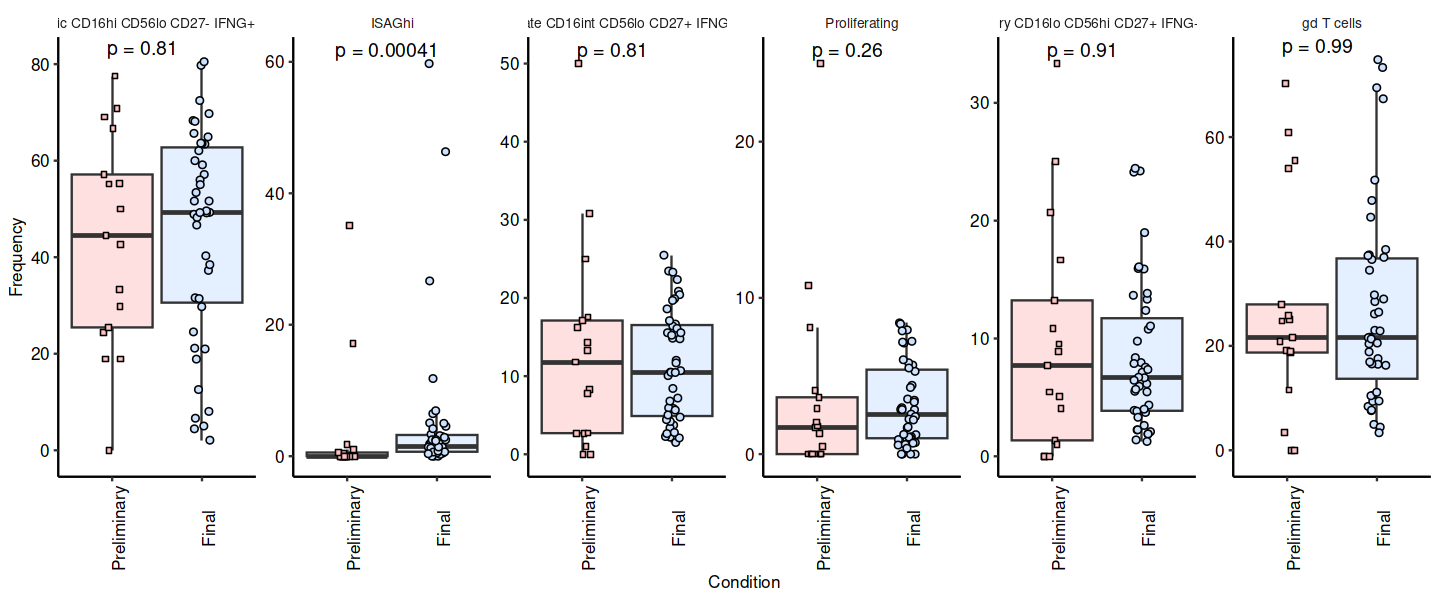

In [179]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [180]:
ggsave("figures/boxplot_nk_subcluster_2.png", width = 16, height = 8, units = "cm")
ggsave("figures/boxplot_nk_subcluster_2.svg", width = 16, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


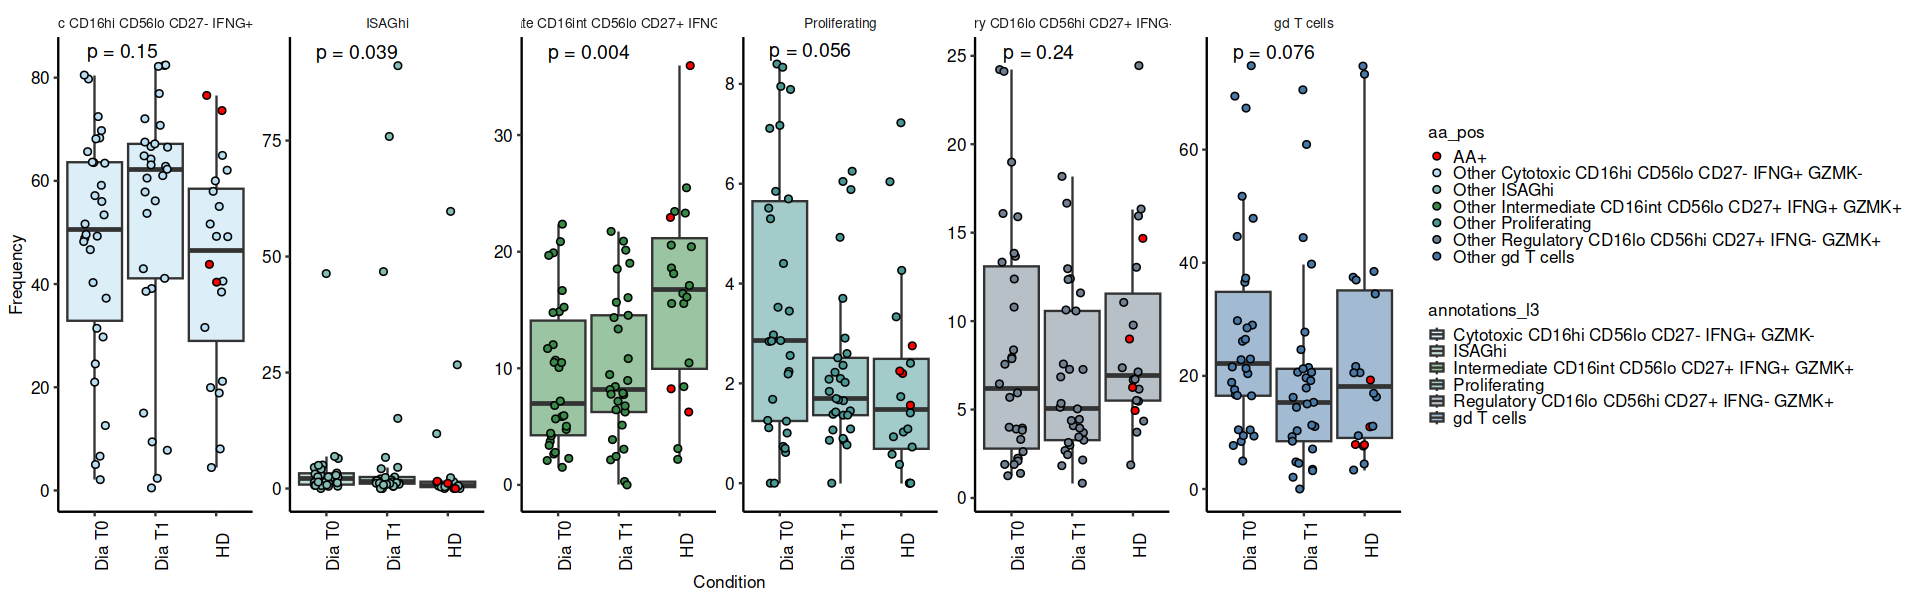

In [383]:
options(repr.plot.width = 16, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l3)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = annotations_l3)) +
  scale_fill_manual(values = c(nk_subcluster@misc$cols_annotations_l3[c(2,8,6,5,1,7,3,4)]))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', aes(fill = aa_pos, shape = aa_pos), color = "black") + 
  scale_fill_manual(values = c("red",nk_subcluster@misc$cols_annotations_l3[c(2,8,6,5,1,7,3,4)]))+
  
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [384]:
ggsave("figures/boxplot_nk_subcluster_3.png", width = 40, height = 8, units = "cm")
ggsave("figures/boxplot_nk_subcluster_3.svg", width = 40, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [269]:
df4

Sample_ID,annotations_l3,freq,Condition,Disease,Sex,Age,Age_group,Patient_ID,Time,Experiment_ID
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
148,Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-,0.50000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,gd T cells,0.11538462,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+,0.30769231,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+,0.07692308,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Proliferating,0.00000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,ISAGhi,0.00000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
149,Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-,0.57142857,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,gd T cells,0.19047619,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+,0.14285714,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08


In [270]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_nk_subcluster.csv", row.names = FALSE)

## Unconventional subcluster

## Cluster composition

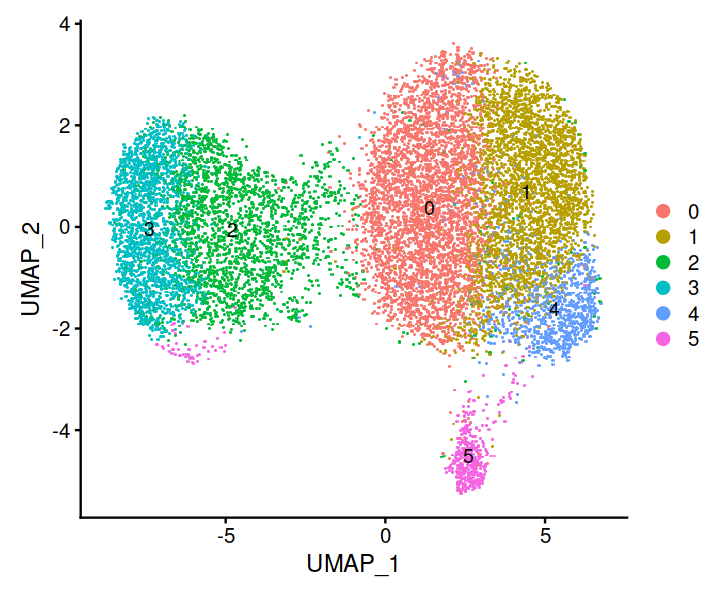

In [194]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(unc_subcluster, label = T, raster = T, pt.size = 2) 
dimplot1

In [241]:
unc_subcluster@meta.data  <- unc_subcluster@meta.data  %>% 
mutate(annotations_l3 = recode_factor(seurat_clusters, 
                                     "0" = "MAIT cells",
                                     "1" = "MAIT cells",
                                     "2" = "gd T cells KIR3DL1lo PTGDSlo CD226lo ZEB2lo XCL1hi",
                                     "3" = "gd T cells KIR3DL1hi PTGDShi CD226hi ZEB2hi",
                                     "4" = "MAIT cells PDE4Dhi OSMhi",
                                     "5" = "MAIT cells ISAGhi"))

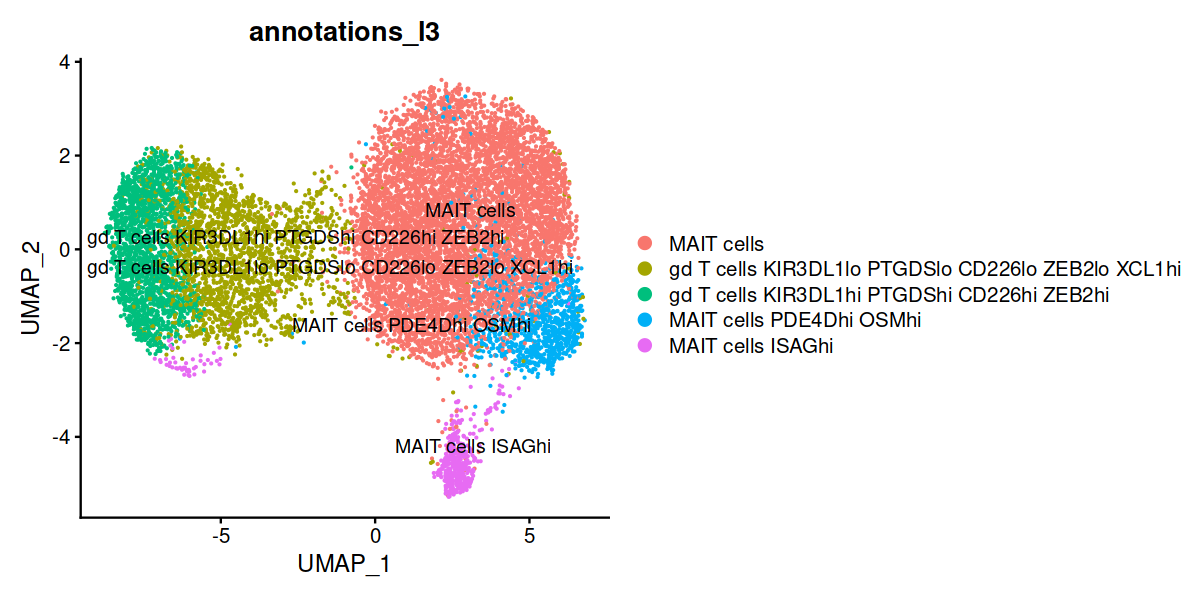

In [243]:
options(repr.plot.width = 10, repr.plot.height = 5)

DimPlot(unc_subcluster, label = T, group.by = "annotations_l3", repel = T)

In [247]:
unc_subcluster@misc$cols_annotations_l3  <- c(
     "#D4A6C8",
    "#89b8da",
     "#4878a6" ,
    "#892ca0ff",
    "#d400aaff")

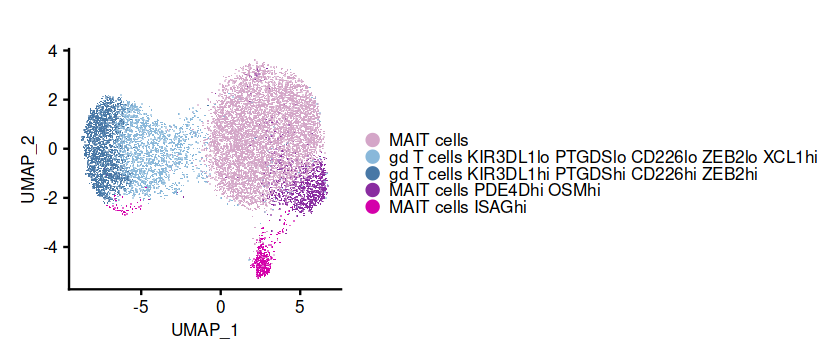

In [253]:
options(repr.plot.width = 7, repr.plot.height = 3)

dimplot1  <- DimPlot(unc_subcluster, label = F, raster = T, group.by = "annotations_l3",
                    cols = unc_subcluster@misc$cols_annotations_l3, pt.size = 2) + 
ggtheme() + 
ggtitle("")
dimplot1

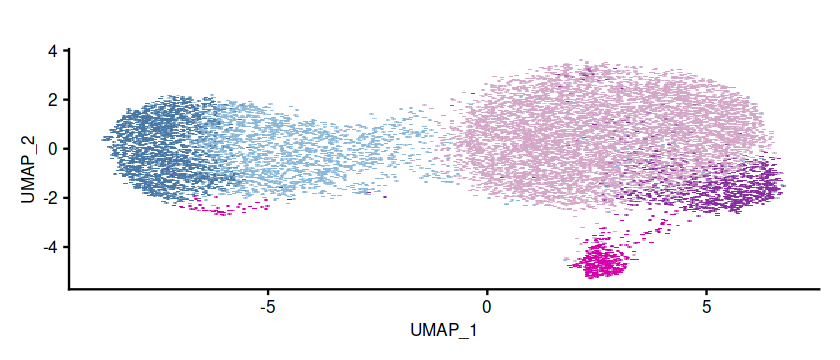

In [254]:
dimplot1 + NoLegend()
ggsave("dimplot_unc_subcluster.png", width = 12, height = 12, units = "cm")
ggsave("dimplot_unc_subcluster.svg", width = 12, height = 12, units = "cm")

In [374]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- unc_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l3) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l3", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l3")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


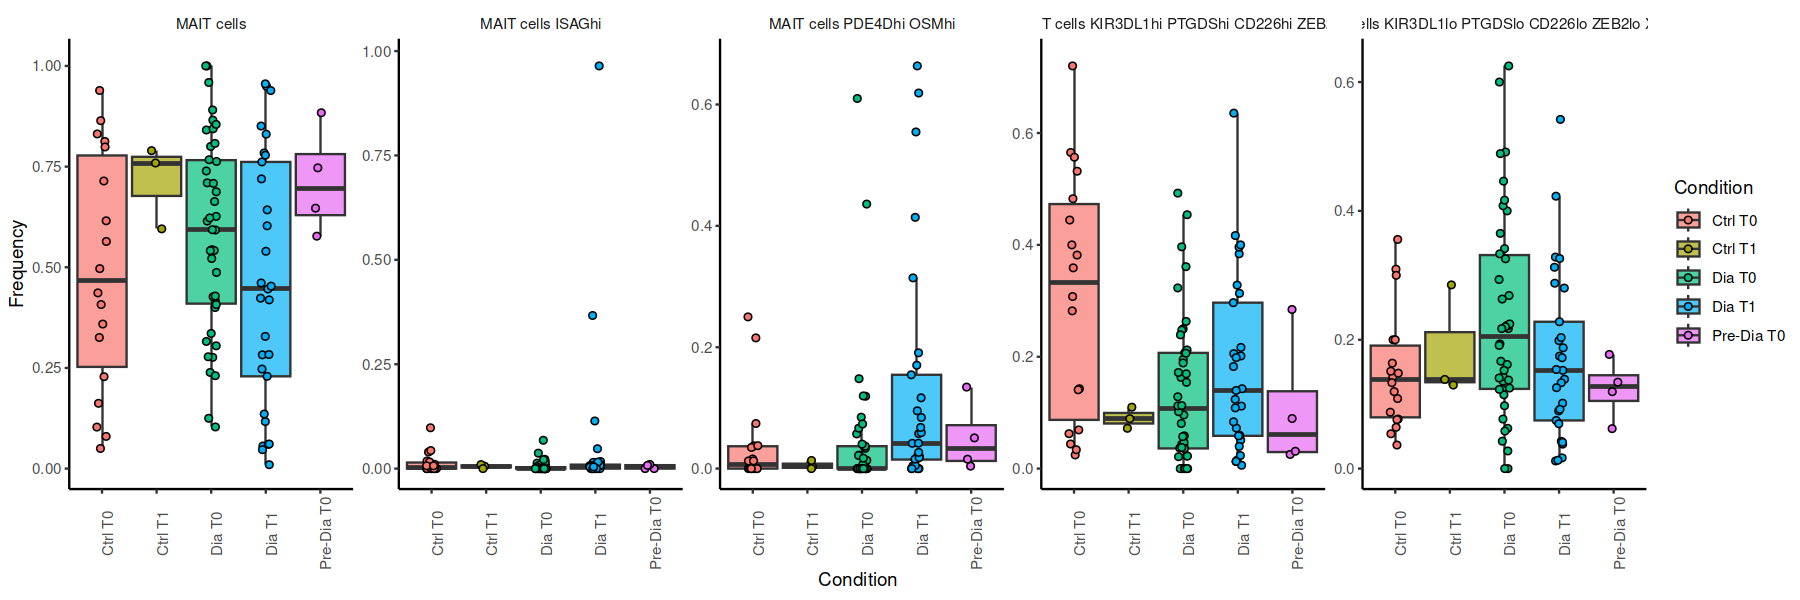

In [250]:
p0

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


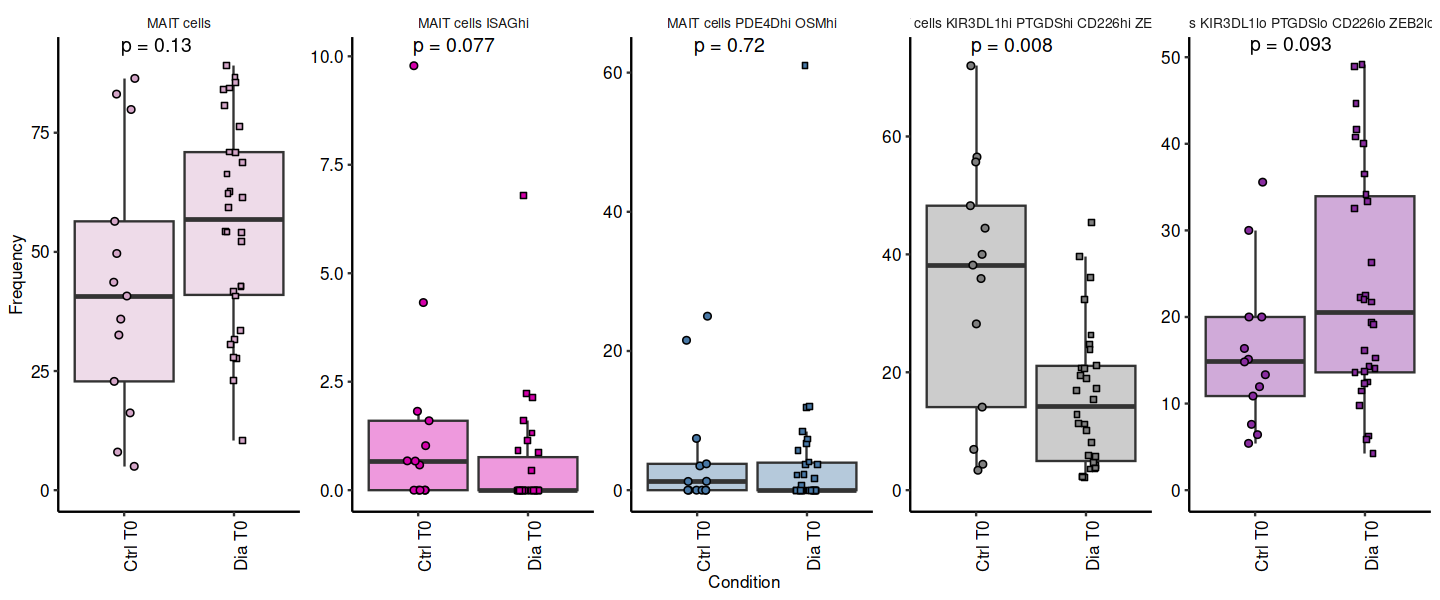

In [251]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l3)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = annotations_l3, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = unc_subcluster@misc$cols_annotations_l3[c(1,5,3,6,4,2)]) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -1, label = "p.format")+
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

In [252]:
ggsave("figures/boxplot_unc_subcluster_1.png", width = 13, height = 8, units = "cm")
ggsave("figures/boxplot_unc_subcluster_1.svg", width = 13, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


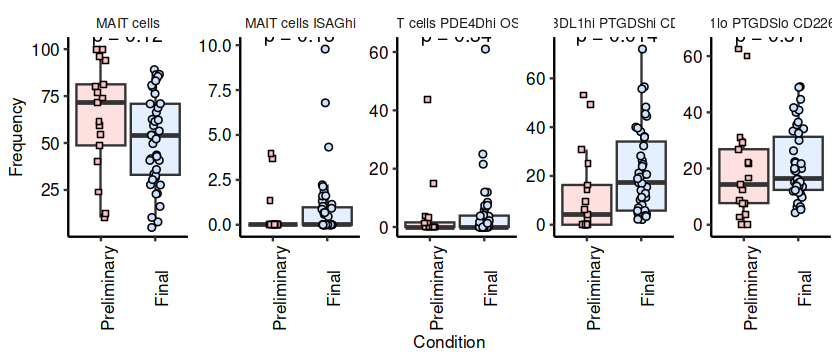

In [255]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 1.5, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [256]:
ggsave("figures/boxplot_unc_subcluster_2.png", width = 13, height = 8, units = "cm")
ggsave("figures/boxplot_unc_subcluster_2.svg", width = 13, height = 8, units = "cm")


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.2, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


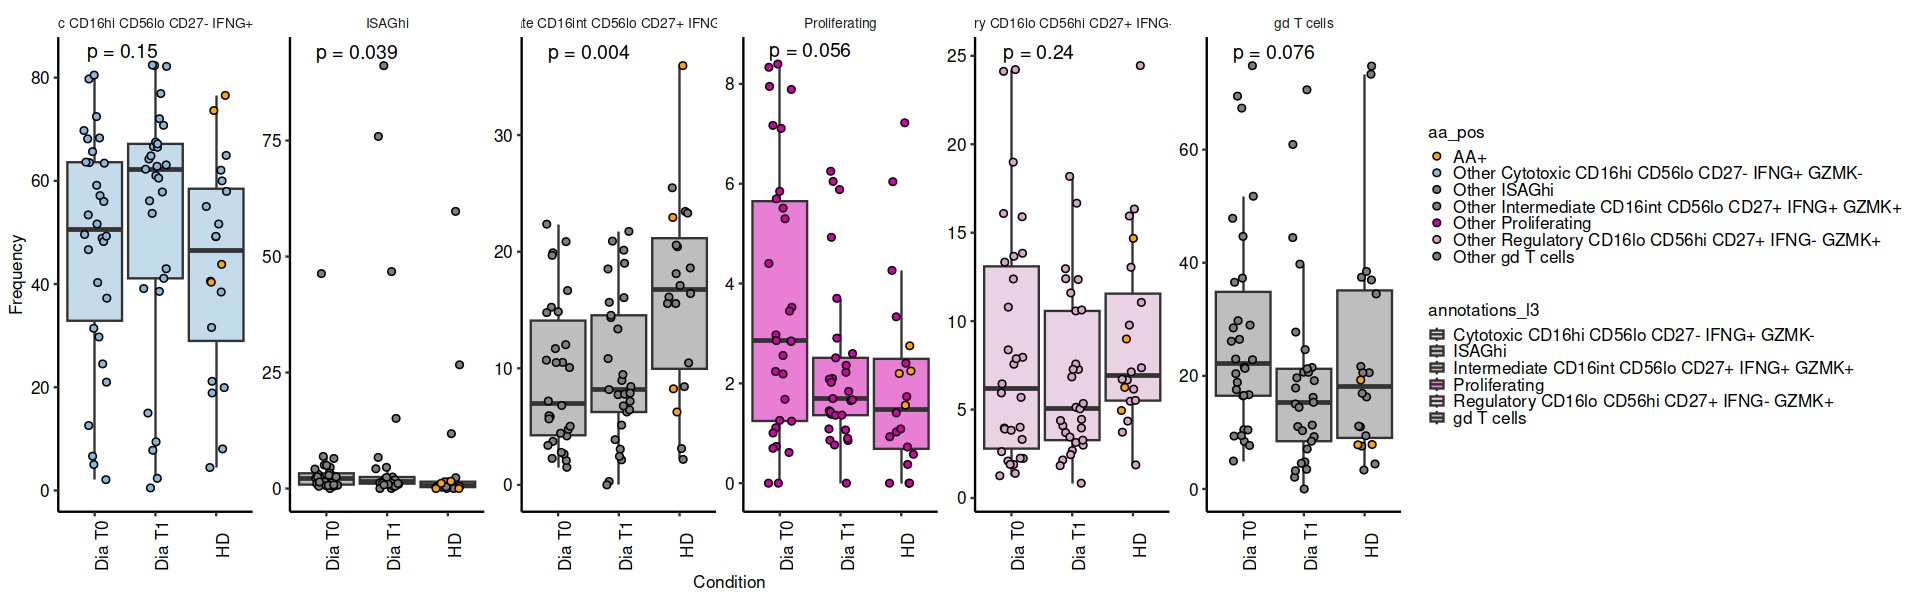

In [380]:
options(repr.plot.width = 16, repr.plot.height = 5)

p3  <- df4  %>% 
mutate(Condition2 = if_else(Disease %in% c("Ctrl", "Pre-Dia"), "HD", Condition))  %>% 
mutate(aa_pos = if_else(Disease %in% c("Pre-Dia"), "AA+", paste("Other", annotations_l3)))  %>% 
filter(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition2, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = annotations_l3)) +
  scale_fill_manual(values = c(unc_subcluster@misc$cols_annotations_l3[c(2,8,6,5,1,7,3,4)]))+
  new_scale_fill() +
  geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
  geom_jitter(binaxis='y', position=position_jitter(width = 0.2, height = 0), 
  size = 1.5, stackdir='center', aes(fill = aa_pos, shape = aa_pos), color = "black") + 
  scale_fill_manual(values = c("orange",unc_subcluster@misc$cols_annotations_l3[c(2,8,6,5,1,7,3,4)]))+
  
  facet_wrap(~annotations_l3, scales = "free", ncol = 9) +
  ylab("Frequency") +
scale_shape_manual(values = c(21,21,21,21,21,21,21,21,21))+
  xlab("Condition") +
  theme_classic() +
ggtheme() +
ggpubr::stat_compare_means(label.x= 1.1, label.y.npc = 1, size = 4, vjust = -0.5, label = "p.format")+
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
p3

In [381]:
ggsave("figures/boxplot_unc_subcluster_3.png", width = 37, height = 8, units = "cm")
ggsave("figures/boxplot_unc_subcluster_3.svg", width = 37, height = 8, units = "cm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### Save freqencies

In [269]:
df4

Sample_ID,annotations_l3,freq,Condition,Disease,Sex,Age,Age_group,Patient_ID,Time,Experiment_ID
<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
148,Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-,0.50000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,gd T cells,0.11538462,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+,0.30769231,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+,0.07692308,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,Proliferating,0.00000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
148,ISAGhi,0.00000000,Ctrl T0,Ctrl,M,8.0,2,201,T0,Exp08
149,Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-,0.57142857,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,gd T cells,0.19047619,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08
149,Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+,0.14285714,Ctrl T0,Ctrl,F,3.0,1,202,T0,Exp08


In [272]:
freq  <- df4  %>% dplyr::select(1:3)
write.csv(freq, "freq_unc_subcluster.csv", row.names = FALSE)

# Tree

In [360]:
cd8_md  <- cd8_full_filt@meta.data  %>% dplyr::select(barcode, annotations_l1)

In [361]:
cd8_md  <- left_join(cd8_md, (cd8_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l2)))

Joining with `by = join_by(barcode)`


In [362]:
cd8_md  <- left_join(cd8_md, (nk_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l3_nk = annotations_l3)))

Joining with `by = join_by(barcode)`


In [363]:
cd8_md  <- left_join(cd8_md, (unc_subcluster@meta.data  %>% dplyr::select(barcode, annotations_l3_unc = annotations_l3)))

Joining with `by = join_by(barcode)`


In [364]:
cd8_md  <- cd8_md  %>% mutate(annotations_l3 = if_else(!is.na(annotations_l3_nk), annotations_l3_nk, annotations_l3_unc))

In [365]:
cd8_md  <- cd8_md  %>% dplyr::select(barcode, annotations_l1, annotations_l2, annotations_l3)

In [366]:
cd8_md  <- cd8_md  %>% mutate(annotations_l2 = if_else(!is.na(annotations_l2), annotations_l2, annotations_l3))  %>% dplyr::select(-annotations_l3)

In [367]:
cd8_md$annotations  <- "CD8"

In [368]:
cd8_md  <- cd8_md  %>% mutate(annotations_l3 = case_when(
annotations_l1 == "CD8 T cells" ~ paste("CD8", annotations_l2),
annotations_l1 == "Unconventional T cells" ~ annotations_l2,
annotations_l1 == "NK cells" ~ paste("NK", annotations_l2)
))

In [369]:
data  <- cd8_md  %>% dplyr::select(-barcode)  %>% 
    group_by(annotations, annotations_l1, annotations_l2)  %>% 
tally()

In [370]:
data

annotations,annotations_l1,annotations_l2,n
<chr>,<fct>,<fct>,<int>
CD8,NK cells,Proliferating,631
CD8,NK cells,Cytotoxic CD16hi CD56lo CD27- IFNG+ GZMK-,11501
CD8,NK cells,gd T cells,5415
CD8,NK cells,Intermediate CD16int CD56lo CD27+ IFNG+ GZMK+,2158
CD8,NK cells,Regulatory CD16lo CD56hi CD27+ IFNG- GZMK+,1534
CD8,NK cells,ISAGhi,1428
CD8,NK cells,NA,2
CD8,CD8 T cells,Tem,13912
CD8,CD8 T cells,Naive,27852


In [373]:
data  %>% write.csv("cd8_tree_sankey.csv", row.names = F)

Sankey plot using https://app.rawgraphs.io/